# Run Pharaglow 

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import tracking, run, features, util

### Load data and create binary masks 

In [3]:
%%time
# io
path = "/media/scholz_la/hd2/Monika"
movie = "MS0002"
fname = os.path.join(path,movie,"*.tiff")
parameterfile = "/home/scholz_la/Desktop/pumping/PharaGlow/pharaglow_parameters_GRU101.txt"
outfile = os.path.join(path, movie+"MS0002_analyzed/_{}_{}.json")
print(outfile)
lawnfile =None#'/media/scholz_la/hd2/Nicolina/Nicolina/Lawns/NZ0040_lawn.bmp'

print('Starting pharaglow analysis...')
rawframes = pims.open(fname)
rawframes = rawframes
print('Loading parameters from {}'.format(parameterfile.split('/')[-2:]))
with open(parameterfile) as f:
    param = json.load(f)

if lawnfile is not None:
    print('open and binarize lawn file')
    lawn = pims.open(lawnfile)[0]
    binLawn = features.findLawn(lawn)
    

/media/scholz_la/hd2/Monika/MS0002MS0002_analyzed/_{}_{}.json
Starting pharaglow analysis...
Loading parameters from ['PharaGlow', 'pharaglow_parameters_GRU101.txt']
CPU times: user 130 ms, sys: 12.3 ms, total: 142 ms
Wall time: 256 ms


### Improve lawn detection if neccessary

In [4]:
if lawnfile is not None:
    from skimage.filters import threshold_li, gaussian, threshold_yen, threshold_otsu
    from skimage.morphology import skeletonize, watershed, disk, remove_small_holes, remove_small_objects
    image = gaussian(lawn, 5, preserve_range = True)
    thresh = threshold_li(image)
    binary = image > thresh*0.8
    binary = remove_small_holes(binary, area_threshold=15000, connectivity=1, in_place=False)
    binary = remove_small_objects(binary, min_size=50000, connectivity=8, in_place=False)
    binLawn = binary
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(lawn)
    plt.subplot(122)
    plt.imshow(binLawn)

### Create binary masks

In [5]:
%%time
# detecting objects
print('Binarizing images')
masks = tracking.calculateMask(rawframes, minSize = param['minSize'], bgWindow = param['bgWindow']
                               , thresholdWindow = param['thresholdWindow'], smooth =  param['smooth'],
                               subtract =  param['subtract'], dilate =2 , tfactor=0.5)


Binarizing images
CPU times: user 8.12 s, sys: 2.58 s, total: 10.7 s
Wall time: 10.7 s


### Make sure the thesholding worked otherwise change parameters

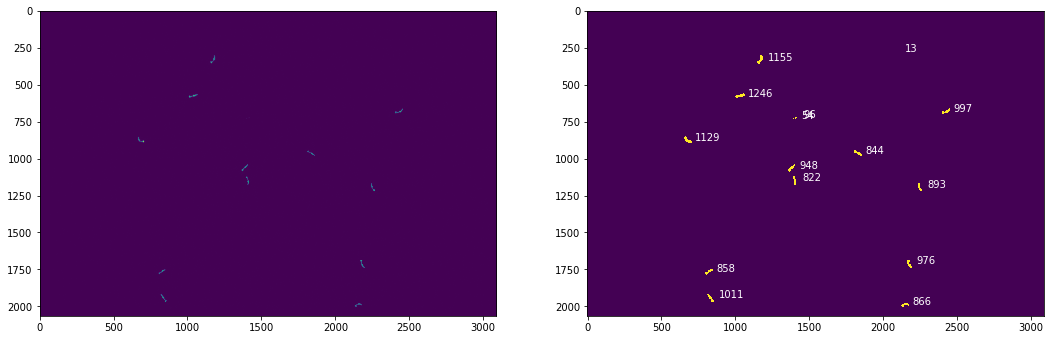

In [7]:
from skimage.measure import label, regionprops
t =1200
plt.figure(figsize=(18,16))
plt.subplot(121)
plt.imshow(rawframes[t])#+lawn)
plt.subplot(122)
plt.imshow(masks[t])#[:600,1000:])#[500:1500,2000:3500])#[:,2500:])
label_image = label(masks[t], background=0, connectivity = 1)
for region in regionprops(label_image):
    plt.text(region.centroid[1]+50, region.centroid[0], region.area, color ='w')

### Detecting individual objects and tracking or use multiprocessing to speed up feature detection

In [ ]:
%%time
import time

nWorkers = 5
if nWorkers ==1:

    #masks = tracking.preprocess(rawframes, minSize = param['minSize'], threshold =None )
    print('Detecting features')
    features = tracking.runfeatureDetection(rawframes, masks, param, frameOffset = 0)
else:
    from multiprocessing import Pool
    print('Detecting features')
    def f(sl):
        a,b = sl
        if len(rawframes[a:b])>1:
            return tracking.runfeatureDetection(rawframes[a:b+1], masks[a:b+1], param, frameOffset = a)
    features = []
    L = len(rawframes)
    # create chunks of analysis based on how many workers we use
    print(L)
    chunksize = L//nWorkers//20
    #slices = np.arange(L)
    slices = zip((range(0,L, chunksize)), (range(chunksize,L+chunksize, chunksize)))
    
    p = Pool(processes = nWorkers)
    start = time.time()
    for k, res in enumerate(p.imap_unordered(f, slices)):
        features.append(res)
        if k == nWorkers:
            print('Expected time is approx. {} s'.format((L/chunksize-k)*(time.time()-start)/nWorkers/2))
        #print(p, time.time()-start)
    features = pd.concat(features)
    p.close()
    p.join()

Detecting features
9001
Expected time is approx. 2527.9837993229758 s


In [ ]:
### Show the area of all objects
plt.plot(np.sort(features['area'].values))

### Save features

In [ ]:
features.head(5)
features.info(memory_usage='deep')
features.to_json(outfile.format('features', 'all'), orient='split')

### Load all features

In [24]:
features = pd.read_json(outfile.format('features', 'all'), orient='split', numpy = True)

/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'numpy' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'numpy'
  """Entry point for launching an IPython kernel.


### Link objects to trajectories and interpolate short misses

In [28]:
print('Done')
print('Linking trajectories')
pred = tp.predict.NearestVelocityPredict()
trajectories = pred.link_df(features,param['searchRange'], memory = param['memory'])

Frame 8999: 13 trajectories present.


In [29]:
print('Interpolating trajectories')
traj = []
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    traj.append(tracking.interpolateTrajectories(tmp))
trajectories = pd.concat(traj, ignore_index = True)
trajectories['shapeX'] = trajectories['shapeX'].astype(int)
trajectories['shapeY'] = trajectories['shapeY'].astype(int)

Interpolating trajectories


In [30]:
print(trajectories['particle'].nunique())
trajectories = tp.filter_stubs(trajectories,param['minimalDuration'])
print(trajectories['particle'].nunique())

216
51


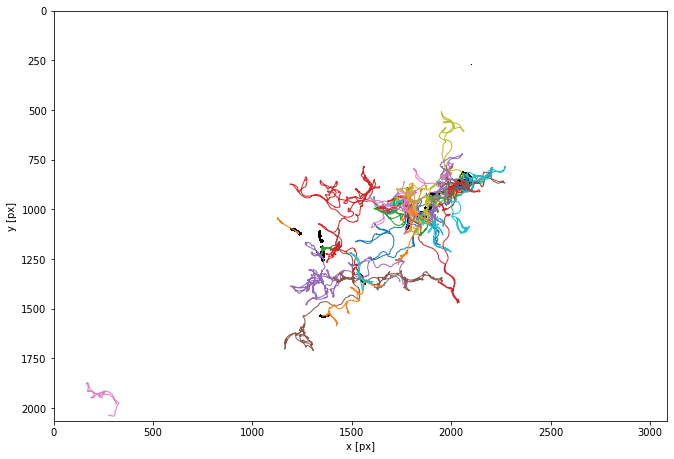

In [34]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories, superimpose=1-masks[8900]);

### add the missing images to interpolated trajectories

In [35]:
%%time
print('Fill in missing images')
from pharaglow import tracking, run, features
# interpolate the shape parameter

trajectories[['image']] = trajectories.apply(\
       lambda row: pd.Series(tracking.fillMissingImages(rawframes, row['frame'], row['x'], row['y'],\
                                               lengthX=row['shapeX'],lengthY=row['shapeY'], size=param['watershed'])) if np.all(np.isnan(row['image'])) else row['image'], axis=1)
trajectories[['diffI']] = trajectories.apply(\
        lambda row: pd.Series(tracking.fillMissingDifferenceImages(rawframes, row['frame'], row['x'], row['y'],\
                                                lengthX=row['shapeX'],lengthY=row['shapeY'], size=param['watershed'])) if np.all(np.isnan(row['diffI'])) else row['diffI'], axis=1)
# trajectories[['diffI']] = trajectories.apply(\
#         lambda row: pd.Series(tracking.fillMissingDifferenceImages(rawframes, row['frame'], row['x'], row['y'],\
#                                                 lengthX=row['shapeX'],lengthY=row['shapeY'], size=param['watershed'])) if np.sum((row['diffI']))==0 else row['diffI'], axis=1)

Fill in missing images
CPU times: user 4min 36s, sys: 3min 14s, total: 7min 50s
Wall time: 20min 48s


### Extract lawn info

In [15]:
%%time

def inside(x,y,binLawn):
    return binLawn[int(y), int(x)]

if lawnfile is not None:
    trajectories['inside'] = trajectories.apply(\
        lambda row: pd.Series(inside(row['x'], row['y'], binLawn)), axis=1)

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 11.4 µs


### Show resulting trajectories

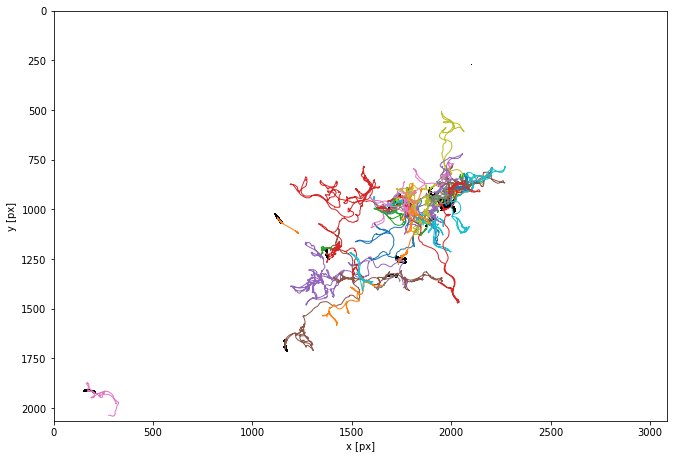

In [16]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories, superimpose=1-masks[290]);

In [36]:
# # write trajectories to separate files.
#trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    tmp.to_json(outfile.format('trajectories', int(particle_index)), orient='split')

### check slow-down before continuing analysis

In [18]:
if lawnfile is not None:
    plt.figure(figsize=(12,8))
    vcut = []
    dt = 350
    for pid in trajectories['particle'].unique():
        tmp = trajectories[['frame', 'x', 'y']][trajectories.loc[:,'particle'] == pid].diff()
        f = (trajectories[['inside']][trajectories.loc[:,'particle'] == pid]).mean().values
        if f<0.9 and f>0.01:
            t0 = np.where((trajectories[['inside']][trajectories.loc[:,'particle'] == pid])==1)[0][0]
            if t0>dt:
                print(pid)
                time = np.linspace(0,2*dt/30., 2*dt)
                v = np.sqrt((tmp['x']**2+tmp['y']**2))/tmp['frame']*30*2.4
                plt.plot(time, v.iloc[t0-dt:t0+dt].values, 'navy', alpha=0.1)
                
                vcut.append(v.iloc[t0-dt:t0+dt].values)
    plt.plot(time, np.mean(np.array(vcut), axis=0), color='navy')
    plt.plot(time, util.smooth(np.mean(np.array(vcut), axis=0), 30), color='r')
    plt.axvline(dt/30, color='k', linestyle='--')
    plt.ylabel(r"velocity ($\mu$m/s)");
    plt.xlabel("time (s)");
    plt.ylim(0,150)


### run the whole pharaglow feature extraction

In [3]:
from multiprocessing import Pool
def parallelize_dataframe(df, func, params, n_cores):
    df_split = np.array_split(df, n_cores)
    print([len(d) for d in df_split])
    pool = Pool(n_cores)
    df = pd.concat(pool.starmap(func, zip(df_split, np.repeat(params, len(df_split)))))
    pool.close()
    pool.join()
    return df

#### run this if acidentally used an odd length like an idiot.

In [4]:
def padIm(im, size = 22500):
    return np.pad(im, (0,size-len(im)), mode='constant', constant_values=0)
def fixImages(trajectories):
    trajectories[['image']] = trajectories.apply(\
       lambda row: pd.Series(padIm(row['image'], row['shapeX']*row['shapeY'])) if len(row['image'])<row['shapeX']*row['shapeY'] else row['image'], axis=1)
    trajectories[['diffI']] = trajectories.apply(\
       lambda row: pd.Series(padIm(row['diffI'], row['shapeX']*row['shapeY'])) if len(row['diffI'])<row['shapeX']*row['shapeY'] else row['diffI'], axis=1)
    

### Save data as json format (every trajectory in a file)

In [5]:
%%time
import os
path = os.path.dirname(outfile)
for fn in os.listdir(path):
    file = os.path.join(path,fn)
    if os.path.isfile(file) and 'trajectories_' in fn and fn.endswith('.json'):
        particle_index = int(fn.split('.')[0].split('_')[-1])
        traj =  pd.read_json(file, orient='split', numpy = True)
        traj['shapeX'] = traj['shapeX'].astype(int)
        print('Analyzing trajectory:', fn)
        # interpolate if images are not the right size:
        fixImages(traj)
        #tmp = run.runPharaglowOnStack(traj, param)
        tmp = parallelize_dataframe(traj, run.runPharaglowOnStack, n_cores = 10, params = param)
        tmp.to_json(outfile.format('results', particle_index), orient='split')
        

/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: the 'numpy' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'numpy'
  import sys


Analyzing trajectory: MS0001_trajectories_10.json
[900, 900, 900, 899, 899, 899, 899, 899, 899, 899]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameter

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_100.json
[128, 128, 128, 128, 127, 127, 127, 127, 127, 127]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: Runtime

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)


Analyzing trajectory: MS0001_trajectories_101.json
[138, 138, 138, 138, 138, 137, 137, 137, 137, 137]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 78 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 76 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 90 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 93 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 89 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 86 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 95 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to sil

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 53 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 100 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 70 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 87 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 94 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 87 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skim

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 99 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 97 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 109 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 114 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 116 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 92 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 78 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 109 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 68 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 81 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 93 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 85 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)


Analyzing trajectory: MS0001_trajectories_104.json
[63, 63, 63, 63, 63, 63, 63, 63, 62, 62]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 96 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 108 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_106.json
[67, 67, 67, 67, 67, 67, 67, 67, 66, 66]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to 

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 90 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skim

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 82 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return con

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 110 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 107 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_108.json
[141, 141, 141, 141, 141, 141, 140, 140, 140, 140]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to 

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 108 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 116 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 84 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 110 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 75 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 118 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_109.json
[148, 148, 148, 148, 148, 148, 148, 147, 147, 147]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 91 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 109 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 118 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 80 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 83 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 107 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 79 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 96 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 92 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 99 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skima

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 76 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 100 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 96 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 78 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 108 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skim

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 101 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 85 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 110 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 110 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 116 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 76 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 110 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 108 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 99 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 104 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

Analyzing trajectory: MS0001_trajectories_11.json
[870, 870, 869, 869, 869, 869, 869, 869, 869, 869]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWar

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to 

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 104 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 116 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_110.json
[144, 144, 144, 143, 143, 143, 143, 143, 143, 143]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 94 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 96 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 98 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 94 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_115.json
[95, 95, 95, 95, 95, 95, 95, 95, 94, 94]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to 

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)


Analyzing trajectory: MS0001_trajectories_12.json
[109, 109, 109, 109, 108, 108, 108, 108, 108, 108]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 118 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_121.json
[112, 112, 111, 111, 111, 111, 111, 111, 111, 111]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 88 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 71 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 58 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 87 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 62 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 106 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 121 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 89 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 88 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 97 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 94 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 74 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 95 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skim

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 61 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 110 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 111 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 111 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_46.json
[92, 92, 92, 92, 92, 92, 92, 92, 92, 92]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 61 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 84 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 82 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_5.json
[900, 900, 900, 900, 900, 900, 900, 900, 900, 899]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_50.json
[677, 677, 677, 677, 677, 677, 677, 677, 677, 676]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  catego

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_52.json
[84, 83, 83, 83, 83, 83, 83, 83, 83, 83]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_59.json
[129, 129, 129, 129, 128, 128, 128, 128, 128, 128]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_6.json
[258, 258, 258, 258, 258, 258, 258, 258, 258, 258]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 116 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to 

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 96 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 93 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 84 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 73 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 110 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 111 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)


Analyzing trajectory: MS0001_trajectories_70.json
[107, 107, 107, 107, 107, 107, 107, 106, 106, 106]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 121 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 102 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_8.json
[691, 691, 691, 691, 691, 691, 691, 690, 690, 690]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/opt

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_83.json
[124, 124, 124, 124, 124, 124, 124, 123, 123, 123]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  catego

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 93 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 91 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 89 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skim

/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 79 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 109 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 64 fits in uint8
  return conv

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 57 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 111 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 66 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 93 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 91 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skim

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 84 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 66 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 63 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 74 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 100 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 92 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 116 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 95 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 106 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 74 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 85 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 106 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

Analyzing trajectory: MS0001_trajectories_85.json
[102, 102, 102, 102, 102, 102, 102, 101, 101, 101]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by r

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 79 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 94 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 76 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 108 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 121 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 121 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 114 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_92.json
[106, 106, 106, 106, 106, 106, 106, 106, 106, 105]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 109 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 116 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 118 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 79 fits in uint8
  return con

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 79 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 95 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 112 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 108 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 94 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 114 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 73 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 94 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 106 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 107 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 80 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 81 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 84 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skim

Analyzing trajectory: MS0001_trajectories_95.json
[73, 72, 72, 72, 72, 72, 72, 72, 72, 72]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_96.json
[592, 592, 592, 592, 592, 592, 591, 591, 591, 591]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_99.json
[146, 146, 146, 146, 145, 145, 145, 145, 145, 145]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 114 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_139.json
[228, 228, 228, 228, 228, 227, 227, 227, 227, 227]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to 

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_140.json
[77, 77, 77, 76, 76, 76, 76, 76, 76, 76]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 106 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_147.json
[162, 162, 162, 162, 162, 162, 162, 162, 162, 161]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWar

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to 

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_148.json
[184, 184, 184, 184, 184, 184, 183, 183, 183, 183]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 103 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 102 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 116 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 85 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 109 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 112 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_149.json
[68, 68, 68, 68, 68, 68, 67, 67, 67, 67]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 108 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 105 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 104 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 102 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 87 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 89 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 103 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 106 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 100 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 237 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 88 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 94 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 97 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 118 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 112 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 102 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_15.json
[283, 283, 283, 283, 283, 283, 282, 282, 282, 282]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_155.json
[118, 118, 118, 118, 118, 117, 117, 117, 117, 117]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWar

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 118 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)


Analyzing trajectory: MS0001_trajectories_161.json
[230, 230, 230, 230, 229, 229, 229, 229, 229, 229]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to 

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 118 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 114 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 121 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 105 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 103 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 118 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 114 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 108 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_162.json
[63, 63, 63, 63, 63, 63, 63, 63, 63, 62]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 95 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 100 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 99 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 102 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_163.json
[123, 123, 122, 122, 122, 122, 122, 122, 122, 122]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 93 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 92 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 116 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 99 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 85 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 111 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 83 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 109 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 108 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_168.json
[200, 200, 200, 200, 199, 199, 199, 199, 199, 199]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  catego

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)


Analyzing trajectory: MS0001_trajectories_17.json
[82, 82, 82, 82, 82, 82, 82, 82, 82, 82]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  catego

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 103 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 81 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 110 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 118 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 114 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_170.json
[109, 109, 109, 109, 109, 109, 109, 108, 108, 108]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to 

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 119 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 107 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_176.json
[78, 78, 78, 78, 78, 78, 78, 78, 78, 78]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameter

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to 

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 114 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 94 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 86 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 107 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 98 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

Analyzing trajectory: MS0001_trajectories_177.json
[63, 63, 63, 63, 63, 63, 63, 63, 63, 62]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_185.json
[89, 89, 88, 88, 88, 88, 88, 88, 88, 88]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 94 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 46 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 77 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 112 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 116 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 110 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 121 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 105 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 104 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_187.json
[67, 67, 67, 66, 66, 66, 66, 66, 66, 66]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 107 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 106 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 72 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 75 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return conv

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 105 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 62 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 71 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 91 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skim

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 66 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 92 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 67 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skim

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 82 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 110 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 68 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 70 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 83 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skim

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 69 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 64 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/ski

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 92 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 67 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 73 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 64 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 66 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 60 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimag

Analyzing trajectory: MS0001_trajectories_188.json
[102, 102, 101, 101, 101, 101, 101, 101, 101, 101]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 66 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 57 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 102 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 162 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 121 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 111 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 124 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 21 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

Analyzing trajectory: MS0001_trajectories_189.json
[96, 96, 96, 95, 95, 95, 95, 95, 95, 95]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/opt

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 234 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to 

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)


Analyzing trajectory: MS0001_trajectories_192.json
[87, 87, 87, 87, 86, 86, 86, 86, 86, 86]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWar

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 128 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_30.json
[112, 112, 112, 111, 111, 111, 111, 111, 111, 111]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 123 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_4.json
[211, 211, 211, 210, 210, 210, 210, 210, 210, 210]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 110 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 108 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 107 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 108 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 106 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 97 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 105 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

Analyzing trajectory: MS0001_trajectories_43.json
[64, 64, 64, 64, 64, 64, 63, 63, 63, 63]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/t

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 160 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 145 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_123.json
[271, 271, 271, 271, 271, 270, 270, 270, 270, 270]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWar

/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 163 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 126 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: MS0001_trajectories_45.json
[239, 239, 239, 238, 238, 238, 238, 238, 238, 238]


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 97 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 102 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 99 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skima

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 115 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 113 fits in uint8
  return co

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 132 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

CPU times: user 3min 23s, sys: 1min 34s, total: 4min 58s
Wall time: 46min 5s


In [22]:
data = pd.read_json(outfile.format('results', '0'), orient='split', numpy = True)


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'numpy' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'numpy'
  """Entry point for launching an IPython kernel.
